<a href="https://colab.research.google.com/github/sudiptiwari/Handwritten-Devanagari-Conjunct-Consonant-Characters/blob/main/code_to_crop_devanagari_characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capture full Image of A4 size paper, Crop it with all the edges of the paper as boundary of the image, and this code automatically crops each individual cell containing Devanagari Characters

## This code works for A4 size paper like this : https://docs.google.com/spreadsheets/d/1_EEi7v7-jDESnWnCg_Z6oKlL8yQTxZLLmKHfJRquQiU/edit

In [ ]:
!pip install pillow pyheif

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib.widgets import Button
# from ipywidgets import Button, HBox, VBox
from PIL import Image
import pyheif
from google.colab import drive
from datetime import datetime

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the image from Google Drive
image_file_name = "IMG_NAME" #Change as per Image File Name
image_path = '/content/drive/My Drive/directory_name' + image_file_name + '.JPG'  # Change this to your image path

## Address the Image according to the extensions

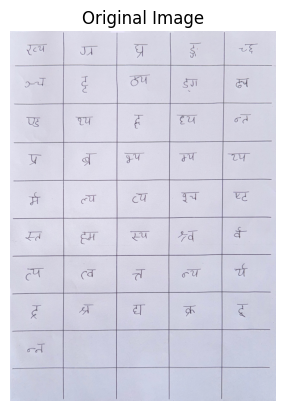

In [ ]:
# Function to determine image format and load image accordingly
def read_image(image_path):
    file_extension = os.path.splitext(image_path)[1].lower()

    # Handle HEIC/HEIF format
    if file_extension in ['.heic', '.heif']:
        heif_file = pyheif.read(image_path)
        image = Image.frombytes(
            heif_file.mode,  # e.g., "RGB"
            heif_file.size,  # e.g., (width, height)
            heif_file.data,  # Raw image data bytes
            "raw",           # Specifying raw format
            heif_file.mode,
            heif_file.stride, # Number of bytes per line
        )

    # Handle JPG/JPEG format
    elif file_extension in ['.jpg', '.jpeg']:
        image = Image.open(image_path)

    # Handle PNG format
    elif file_extension == '.png':
        image = Image.open(image_path)

    else:
        raise ValueError(f"Unsupported image format: {file_extension}")

    return image

# Load Image
image = read_image(image_path)

# Display the image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

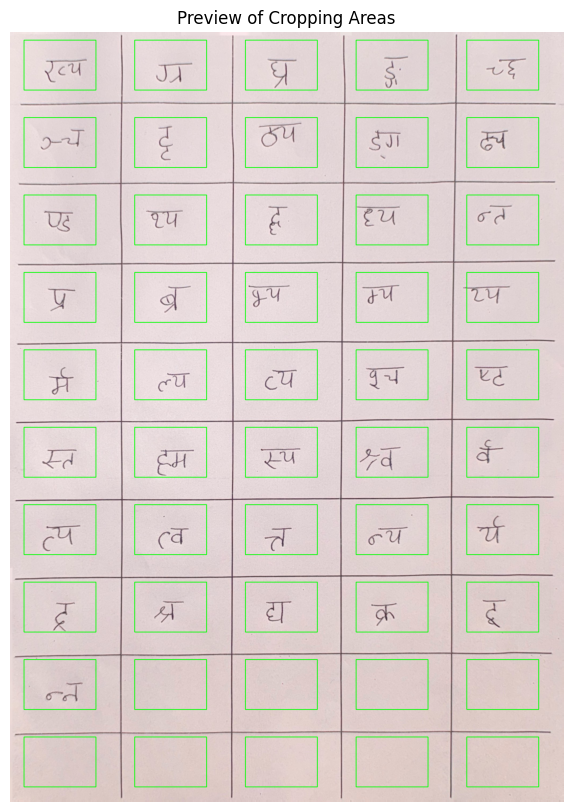

In [ ]:
# Convert PIL image to NumPy array for easier cropping
image_np = np.array(image)

# Get image dimensions
height, width, _ = image_np.shape

# Define rows and columns
rows = 10
columns = 5

# Calculate box dimensions
box_height = height // rows
box_width = width // columns

# Define central crop dimensions (e.g., 60% of the box size)
# Larger the value, bigger the box
############################# YOU CAN CHANGE THIS VALUE #############################
central_crop_factor = 0.65
central_box_height = int(box_height * central_crop_factor)
central_box_width = int(box_width * central_crop_factor)

# Offsets for centering the crop
y_offset = (box_height - central_box_height) // 2
x_offset = (box_width - central_box_width) // 2

# Offset step for row-specific clipping
############################# YOU CAN CHANGE THIS VALUE #############################
# offset_step = int(0.002 * height)
offset_step = int(0.001 * height)
# offset_step = int(0.0 * height)

# Move cropped boxes up and left
############################# YOU CAN CHANGE THIS VALUE #############################
move_box_up = 0
# move_box_up = 30
# move_box_up = 40
# move_box_up = 100

############################# YOU CAN CHANGE THIS VALUE #############################
# move_box_left = 0
move_box_left = 20
# move_box_left = 50
# move_box_left = 100

# Visualization and storing coordinates
visualized_image = image_np.copy()
crop_coordinates = []  # To store the coordinates for cropping later

for row in range(rows):
    for col in range(columns):
        y_start = row * box_height + row * offset_step
        y_end = min(y_start + box_height, height)
        x_start = col * box_width
        x_end = min(x_start + box_width, width)

        # Calculate final coordinates for cropping
        final_y_start = y_start + y_offset - move_box_up
        final_y_end = final_y_start + central_box_height
        final_x_start = x_start + x_offset - move_box_left
        final_x_end = final_x_start + central_box_width

        # Ensure coordinates are within bounds
        final_y_start = max(0, final_y_start)
        final_y_end = min(height, final_y_end)
        final_x_start = max(0, final_x_start)
        final_x_end = min(width, final_x_end)

        # Store coordinates for cropping
        crop_coordinates.append((final_y_start, final_y_end, final_x_start, final_x_end))

        # Draw the bounding box
        cv2.rectangle(visualized_image, (final_x_start, final_y_start), (final_x_end, final_y_end), (0, 255, 0), 2)

# Display the image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(visualized_image, cv2.COLOR_BGR2RGB))
plt.title('Preview of Cropping Areas')
plt.axis('off')
plt.show()

# Generate current date and time for filenames (remains constant for one image)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

## **Save Images**

In [ ]:
# Output directory for cropped images
output_dir = '/content/drive/My Drive/destination_folder_name'
os.makedirs(output_dir, exist_ok=True)

# Save the cropped images
box_counter = 0
############################# YOU CAN CHANGE THIS VALUE #############################
number_of_boxes_to_be_cropped = 50

for coords in crop_coordinates[:number_of_boxes_to_be_cropped]:
    final_y_start, final_y_end, final_x_start, final_x_end = coords

    # Crop the image using the final coordinates
    central_cropped_box = image_np[final_y_start:final_y_end, final_x_start:final_x_end]

    # Create a subdirectory for each image
    subdirectory = os.path.join(output_dir, f'CC_{box_counter + 1}')
    os.makedirs(subdirectory, exist_ok=True)

    # Save the cropped image inside the subdirectory
    box_filename = f'box_{image_file_name}_{timestamp}_{box_counter + 1}.jpg'
    cv2.imwrite(os.path.join(subdirectory, box_filename), central_cropped_box)
    box_counter += 1

print(f"{box_counter} {image_file_name} cropped images have been saved in separate folders under {output_dir}.")